In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from math import pi, sin, cos, tan

# Find SunFounder_PiCar submodule
sys.path.append("../lib")
sys.path.append("../lib/SunFounder_PiCar")

# Custom libraries
from helpers import sign, angle_a2b, within_pi, clip
from my_pid import myPID
import perspectives 
from cartesian_pose import CartesianPose
from bicycle_model  import BicyclePose, BicycleModel
from my_picar_utils import PicarHardwareInterface as Hardware 
from my_picar_utils import MyPicarController as Controller
from my_picar_utils import HardwareUnitConverter as Converter 
from my_picar_utils import MyWorldFrame as World 
from my_picar import Picar

In [2]:
def rotmat(theta):
    return np.array([[cos(theta), -sin(theta)], [sin(theta),cos(theta)]])

WIDTH=.8
HEIGHT=1.2
dims = np.array([HEIGHT,WIDTH])
def plot_wp_rects(ax, allposes):
    for pose in allposes:
        xy = pose[:2]
        th = pose[2]
        correction = np.matmul(rotmat(th), dims)/2
        r = mpl.patches.Rectangle(xy, HEIGHT, WIDTH, angle=th*180/pi, zorder=0)
        r.set_xy(xy-correction)
        ax.add_patch(r)
    

In [3]:
picar = Picar(virtual=True)
rhoPID   = myPID(Kp=1, Kd=0, Ki=0)
alphaPID = myPID(Kp=1, Kd=0, Ki=0)
betaPID  = myPID(Kp=1, Kd=0, Ki=0)

controller = Controller(rhoPID, alphaPID, betaPID)

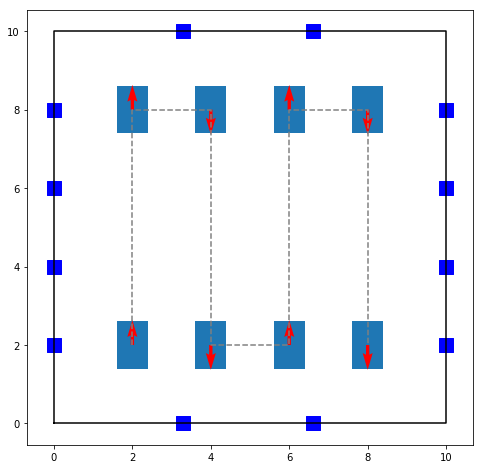

In [4]:
env_lims = np.array([ [0, 10], [0,10] ])

# Coverage strategy: Snake vertically, then horizontally
fig = plt.figure(figsize=(8,8))
plt.plot([0,10,10,0, 0], [0, 0, 10, 10, 0], 'k')
ax = plt.gca()
ax.axis('equal')

QR_codes = {
    "pos" : np.array([ 
                [ 0,   2], [  0,  4], [ 0, 6], [ 0, 8], #left wall
                [ 10,  2], [  10, 4], [10, 6], [10, 8], # right wall
                [3.3,  0], [6.6,  0], # bottom wall
                [3.3, 10], [6.6, 10] # top wall
               ]),
    "id" : np.array([ 1, 2, 2, 1,  # left wall
                      2, 1, 1, 2,  # right wall
                      1, 2,  # bottom wall
                      2, 1   # top wall
                    ])
}


picar_start = np.array([2,2, pi/2])
waypoints = np.array([
    [2,8,  pi/2],
    [4,8, -pi/2],
    [4,2, -pi/2],
    [6,2,  pi/2],
    [6,8,  pi/2],
    [8,8, -pi/2],
    [8,2, -pi/2]
])
allposes = np.insert(waypoints, 0, picar_start, axis=0) 



ax.scatter(QR_codes["pos"][:,0], QR_codes["pos"][:,1], c='b', marker='s', s=200)
plt.plot( allposes[:,0], allposes[:,1], color='gray', ls='--')
plot_wp_rects(ax, allposes)
ax.quiver( allposes[:,0], allposes[:,1], 
           np.cos(allposes[:,2]), np.sin(allposes[:,2]),
           color='r') 

In [5]:
picar.world_pose = picar_start
goal = waypoints[0]

def dist(a,b):
    a = np.array(a)
    b = np.array(b)
    if np.ndim(a)==1:
        a = a[None]
    if np.ndim(b)==1:
        b = b[None]
    return np.squeeze(np.sqrt(np.sum(np.power(a-b,2),axis=1)))

# while ( dist(picar.world_pose, goal) )

In [9]:
picar.world_pose.dist( CartesianPose(goal[0], goal[1], goal[2]))

AttributeError: 'numpy.ndarray' object has no attribute 'dist'